# HMM with Poisson observations for detecting changepoints in the rate of a signal

Based on https://www.tensorflow.org/probability/examples/Multiple_changepoint_detection_and_Bayesian_model_selection


In [1]:
import logging

logging.getLogger("absl").setLevel(logging.CRITICAL)

In [2]:
from jax.config import config

config.update("jax_debug_nans", True)

In [3]:
try:
    import ssm_jax
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    import ssm_jax
ssm_jax.__file__

'/Users/scott/Projects/ssm-jax/ssm_jax/__init__.py'

In [4]:
import jax.numpy as jnp
import jax.random as jr
from jax import vmap

import tensorflow_probability.substrates.jax.distributions as tfd
import optax
from matplotlib import pylab as plt

from ssm_jax.hmm.models import PoissonHMM

## Data

The synthetic data corresponds to a single time series of counts, where the rate of the underlying generative process changes at certain points in time.

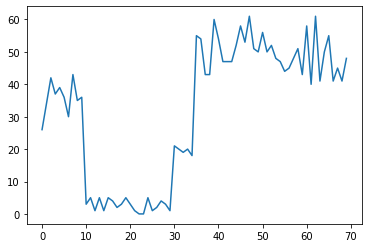

In [5]:
keys = jr.split(jr.PRNGKey(0), 4)
true_rates = jnp.array([40, 3, 20, 50], dtype=jnp.float32)
true_durations = jnp.array([10, 20, 5, 35])
random_state = 0

observed_counts = jnp.concatenate(
    [
        jr.poisson(key, rate, (num_steps,))
        for (key, rate, num_steps) in zip(keys, true_rates, true_durations)
    ]
).astype(jnp.float32)

# PoissonHMM requires are least 1D emissions
observed_counts = observed_counts[:, None]

plt.plot(observed_counts)

## Model with fixed $K$

To model the changing Poisson rate, we use an HMM. We initially assume the number of states is known to be $K=4$. Later we will try comparing HMMs with different $K$.

We fix the initial state distribution to be uniform, and fix the transition matrix to be the following, where we set $p=0.05$:

$$ \begin{align*} z_1 &\sim \text{Categorical}\left(\left\{\frac{1}{K}, \ldots, \frac{1}{K}\right\}\right)\\ z_t | z_{t-1} &\sim \text{Categorical}\left(\left\{\begin{array}{cc}p & \text{if } z_t = z_{t-1} \\ \frac{1-p}{K-1} & \text{otherwise}\end{array}\right\}\right) \end{align*}$$

Now we create an HMM where the observation distribution is a Poisson with learnable parameters. We specify the parameters in log space and initialize them to random values around the log of the overall mean count (to set the scal

## Model fitting using Gradient Descent

We compute a MAP estimate of the Poisson rates $\lambda$ using batch gradient descent, using the Adam optimizer applied to the log likelihood (from the HMM) plus the log prior for $p(\lambda)$.

In [6]:
# Set a weak prior over the rates
rate_prior = tfd.LogNormal(jnp.log(5), 2)

In [7]:
emission_rates = rate_prior.sample(seed=jr.PRNGKey(2), sample_shape=(4, 1))
emission_rates

DeviceArray([[11.780762  ],
             [ 0.8355373 ],
             [ 6.928987  ],
             [ 0.19971596]], dtype=float32)

In [8]:
def fit(num_states, change_prob, rng_key):
    # Construct an HMM with fixed transition matrix and random rates from the prior
    initial_probs = jnp.ones(num_states) / num_states
    transition_matrix = (1 - change_prob) * jnp.eye(num_states) \
        + change_prob / (num_states - 1) * (1 - jnp.eye(num_states))
    emission_rates = rate_prior.sample(seed=rng_key, sample_shape=(num_states, 1))
    hmm = PoissonHMM(initial_probs, transition_matrix, emission_rates)

    # Freeze the initial probabilities and transition matrix
    hmm.initial_probs.freeze()
    hmm.transition_matrix.freeze()

    # Maximize the log joint probability, including the prior
    optimizer = optax.adam(1e-1)
    dataset = observed_counts[None, ...]

    # Define an objective function for the remaining parameters (the rates)
    def loss_fn(params, minibatch):
        hmm.unconstrained_params = params
        scale = len(dataset) / len(minibatch)
        log_likelihood = vmap(hmm.marginal_log_prob)(minibatch).sum() * scale
        log_prior = rate_prior.log_prob(hmm.emission_rates.value).sum()
        return -(log_prior + log_likelihood) / minibatch.size
        

    from ssm_jax.optimize import run_sgd
    num_epochs = 1000
    params, losses = run_sgd(loss_fn, 
                            hmm.unconstrained_params, 
                            dataset, 
                            batch_size=1,
                            optimizer=optimizer, 
                            num_epochs=num_epochs)
    hmm.unconstrained_params = params
    return hmm, losses


In [9]:
# Set a weak prior over the rates
hmm, losses = fit(4, 0.05, jr.PRNGKey(0))
print("Inferred rates: {}".format(hmm.emission_rates.value))
print("True rates: {}".format(true_rates))

Inferred rates: [[72.34557   ]
 [ 0.09770663]
 [42.01979   ]
 [ 2.6816597 ]]
True rates: [40.  3. 20. 50.]


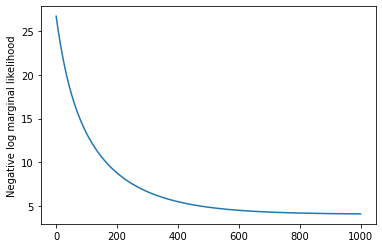

In [10]:
plt.plot(losses)
plt.ylabel("Negative log marginal likelihood");

We see that the method learned a good approximation to the true (generating) parameters, up to a permutation of the states (since the labels are unidentifiable). However, results can vary with different random seeds. We may find that the rates are the same for some states, which means those states are being treated as identical, and are therefore redundant.

## Plotting the posterior over states

In [11]:
posterior = hmm.smoother(observed_counts)
posterior_probs = posterior.smoothed_probs
rates = hmm.emission_rates.value

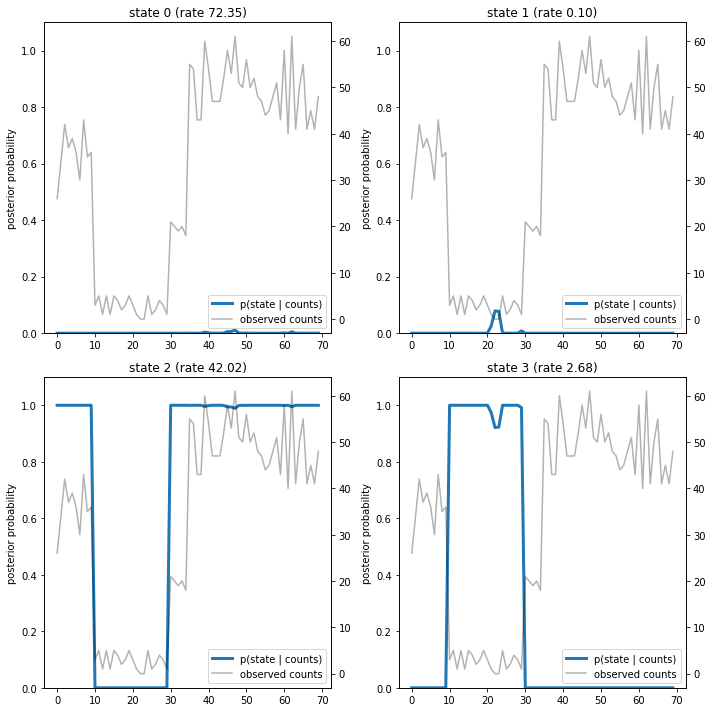

In [12]:
def plot_state_posterior(ax, state_posterior_probs, title):
    ln1 = ax.plot(state_posterior_probs, c="tab:blue", lw=3, label="p(state | counts)")
    ax.set_ylim(0.0, 1.1)
    ax.set_ylabel("posterior probability")
    ax2 = ax.twinx()
    ln2 = ax2.plot(observed_counts, c="black", alpha=0.3, label="observed counts")
    ax2.set_title(title)
    ax2.set_xlabel("time")
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=4)
    ax.grid(True, color="white")
    ax2.grid(False)


fig = plt.figure(figsize=(10, 10))
plot_state_posterior(fig.add_subplot(2, 2, 1), posterior_probs[:, 0], title="state 0 (rate {:.2f})".format(rates[0,0]))
plot_state_posterior(fig.add_subplot(2, 2, 2), posterior_probs[:, 1], title="state 1 (rate {:.2f})".format(rates[1,0]))
plot_state_posterior(fig.add_subplot(2, 2, 3), posterior_probs[:, 2], title="state 2 (rate {:.2f})".format(rates[2,0]))
plot_state_posterior(fig.add_subplot(2, 2, 4), posterior_probs[:, 3], title="state 3 (rate {:.2f})".format(rates[3,0]))
plt.tight_layout()

In [13]:
# max marginals
most_probable_states = hmm.most_likely_states(observed_counts)
most_probable_rates = hmm.emission_rates.value[most_probable_states]

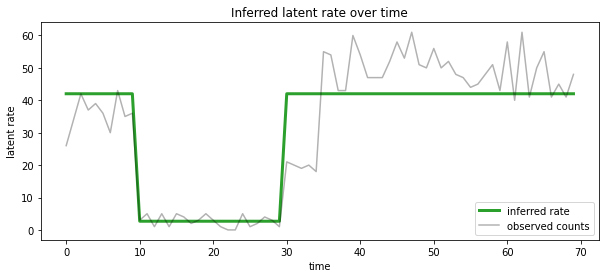

In [14]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c="tab:green", lw=3, label="inferred rate")
ax.plot(observed_counts, c="black", alpha=0.3, label="observed counts")
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time")
ax.legend(loc=4);

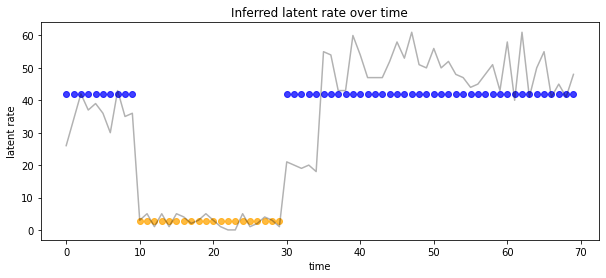

In [15]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
color_list = ["red", "green", "blue", "orange", "purple", "brown"]
colors = [color_list[k] for k in most_probable_states]
for t in range(len(colors)):
    ax.plot(t, most_probable_rates[t], "-o", c=colors[t], lw=3, alpha=0.75)
ax.plot(observed_counts, c="black", alpha=0.3, label="observed counts")
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time");

## Model with unknown $K$

In general we don't know the true number of states. One way to select the 'best' model is to compute the one with the maximum marginal likelihood. Rather than summing over both discrete latent states and integrating over the unknown parameters $\lambda$, we just maximize over the parameters (empirical Bayes approximation).

$$p(x_{1:T}|K) \approx \max_\lambda \int p(x_{1:T}, z_{1:T} | \lambda, K) dz$$
We can do this by fitting a bank of separate HMMs, one for each value of $K$.

In [16]:
max_num_states = 6
num_restarts = 5
poss_num_states = jnp.arange(2, max_num_states + 1)

rng_key = jr.PRNGKey(0)

all_results = []
for num_states in poss_num_states:
    print("Fitting HMM with ", num_states, "states")
    these_results = []
    for restart in range(num_restarts):
        print("restart ", restart + 1)
        rng_key, this_rng_key = jr.split(rng_key, 2)
        these_results.append(fit(num_states, 0.05, this_rng_key))
    all_results.append(these_results)
    print("")

Fitting HMM with  2 states
restart  1
restart  2
restart  3
restart  4
restart  5

Fitting HMM with  3 states
restart  1
restart  2
restart  3
restart  4
restart  5

Fitting HMM with  4 states
restart  1
restart  2
restart  3
restart  4
restart  5

Fitting HMM with  5 states
restart  1
restart  2
restart  3
restart  4
restart  5

Fitting HMM with  6 states
restart  1
restart  2
restart  3
restart  4
restart  5



## Plot marginal likelihood of each model

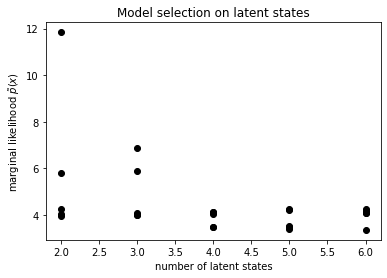

In [17]:
best_loss = jnp.inf
best_hmm = None
for num_states, results_k in zip(poss_num_states, all_results):
    for (hmm, losses) in results_k:
        plt.plot(num_states, losses[-1], 'ko')
        if losses[-1] < best_loss:
            best_loss = losses[-1]
            best_hmm = hmm

# plt.ylim([-400, -200])
plt.ylabel("marginal likelihood $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.title("Model selection on latent states");

## Plot posteriors

In [18]:
best_rates = best_hmm.emission_rates.value
print("best model's rates")
print(best_rates)


best model's rates
[[35.681393  ]
 [ 0.09442115]
 [19.354198  ]
 [ 0.09442115]
 [ 2.6755857 ]
 [49.642437  ]]


In [19]:
# Get the most probable states under best model and corresponding rates
most_probable_states = best_hmm.most_likely_states(observed_counts)
most_probable_rates = best_hmm.emission_rates.value[most_probable_states]

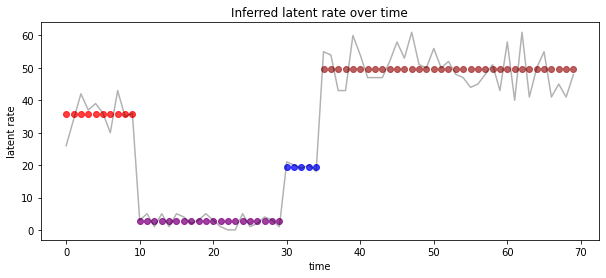

In [20]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
color_list = ["red", "green", "blue", "orange", "purple", "brown"]
colors = [color_list[k] for k in most_probable_states]
for t in range(len(colors)):
    ax.plot(t, most_probable_rates[t], "-o", c=colors[t], lw=3, alpha=0.75)
ax.plot(observed_counts, c="black", alpha=0.3, label="observed counts")
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time");